Total samples: 57477
Training samples (80%): 45981
Validation samples (10%): 5748
Internal test samples (10%): 5748
Fitting classifier with 114 bins...

Fit Statistics:
Number of samples: 45981
Length difference range: [-52573, 22234]

Bin Edges:
Length Difference: [-5.25730000e+04 -3.03500000e+03 -2.33866667e+03 -2.00500000e+03
 -1.78800000e+03 -1.63233333e+03 -1.48800000e+03 -1.37766667e+03
 -1.28933333e+03 -1.21800000e+03 -1.14500000e+03 -1.08400000e+03
 -1.02300000e+03 -9.69000000e+02 -9.19333333e+02 -8.70000000e+02
 -8.26000000e+02 -7.84333333e+02 -7.45000000e+02 -7.06000000e+02
 -6.68000000e+02 -6.35000000e+02 -6.04000000e+02 -5.72000000e+02
 -5.45000000e+02 -5.17000000e+02 -4.91333333e+02 -4.64000000e+02
 -4.38000000e+02 -4.14000000e+02 -3.93000000e+02 -3.68000000e+02
 -3.47000000e+02 -3.26000000e+02 -3.03000000e+02 -2.83333333e+02
 -2.65000000e+02 -2.47000000e+02 -2.27000000e+02 -2.11000000e+02
 -1.94000000e+02 -1.78000000e+02 -1.63000000e+02 -1.49000000e+02
 -1.33000000e+02 -1

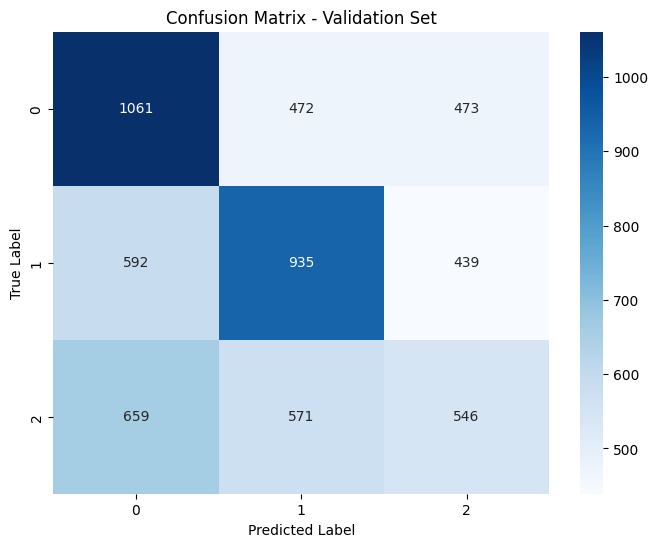


Classification Report - Internal Test Set
              precision    recall  f1-score   support

           0       0.46      0.53      0.49      2007
           1       0.46      0.46      0.46      1965
           2       0.38      0.31      0.34      1776

    accuracy                           0.44      5748
   macro avg       0.43      0.43      0.43      5748
weighted avg       0.43      0.44      0.43      5748



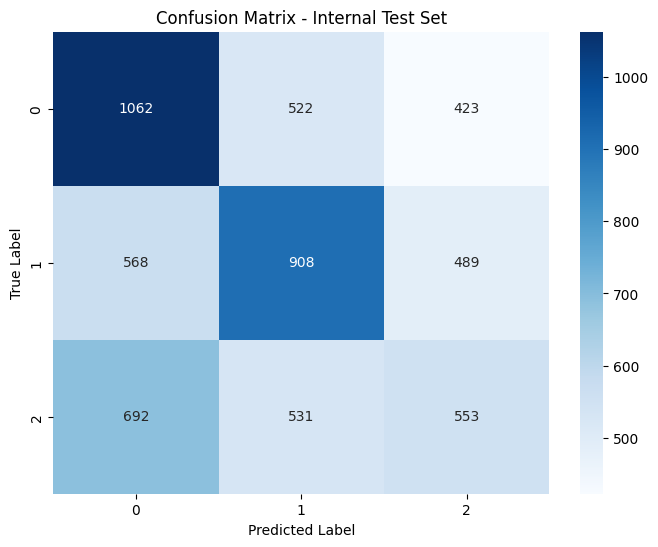


Metrics Comparison:
{'Validation': {'test_loss': np.float64(1.0611438819081882), 'test_cross_entropy_loss': np.float64(1.0611438819081882), 'test_accuracy': 0.44224077940153095, 'test_precision': 0.43754132790620937, 'test_recall': 0.44224077940153095, 'test_f1': 0.4380053075372568, 'test_runtime': 0.2114090919494629, 'test_samples_per_second': 27188.99148090591, 'test_steps_per_second': 424.8279918891548}, 'Test': {'test_loss': np.float64(1.0607801403370487), 'test_cross_entropy_loss': np.float64(1.0607801403370487), 'test_accuracy': 0.43893528183716074, 'test_precision': 0.4346167167840113, 'test_recall': 0.43893528183716074, 'test_f1': 0.43488402960340744, 'test_runtime': 0.21158599853515625, 'test_samples_per_second': 27166.258825226265, 'test_steps_per_second': 424.4727941441604}}


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import time

class LengthBasedClassifier:
    def __init__(self, n_bins=15):
        self.n_bins = n_bins
        self.length_diff_bins = None
        self.probability_table = None
        self.bin_edges = {}
        
    def fit(self, df):
        print(f"Fitting classifier with {self.n_bins} bins...")
        
        df['length_diff'] = df['response_a'].str.len() - df['response_b'].str.len()
        
        self.length_diff_bins = KBinsDiscretizer(
            n_bins=self.n_bins, 
            encode='ordinal', 
            strategy='quantile'
        )
        
        length_diff_cat = self.length_diff_bins.fit_transform(df[['length_diff']])
        self.bin_edges['length_diff'] = self.length_diff_bins.bin_edges_[0]
        df['length_diff_cat'] = length_diff_cat
        
        self.probability_table = pd.DataFrame()
        for outcome in ['winner_model_a', 'winner_model_b', 'winner_tie']:
            self.probability_table[outcome] = df.groupby('length_diff_cat')[outcome].mean()
        
        # Print detailed fit statistics
        print("\nFit Statistics:")
        print(f"Number of samples: {len(df)}")
        print(f"Length difference range: [{df['length_diff'].min()}, {df['length_diff'].max()}]")
        print("\nBin Edges:")
        print("Length Difference:", self.bin_edges['length_diff'])
        
        return self
    
    def predict_proba_batch(self, df):
        df['length_diff'] = df['response_a'].str.len() - df['response_b'].str.len()
        length_diff_cat = self.length_diff_bins.transform(df[['length_diff']])
        
        probs = []
        for cat in length_diff_cat:
            row_probs = self.probability_table.iloc[int(cat[0])]
            probs.append([
                row_probs['winner_model_a'], 
                row_probs['winner_model_b'], 
                row_probs['winner_tie']
            ])
            
        return np.array(probs)

def evaluate_model(model, df, dataset_name="", has_labels=True):
    start_time = time.time()
    
    predictions = model.predict_proba_batch(df)
    pred_labels = np.argmax(predictions, axis=1)
    
    if not has_labels:
        runtime = time.time() - start_time
        return {
            'predictions': predictions,
            'pred_labels': pred_labels,
            'test_runtime': runtime,
            'test_samples_per_second': len(df) / runtime,
            'test_steps_per_second': (len(df) / runtime) / 64
        }
    
    true_labels = (df['winner_model_b'].astype(int) + 
                  df['winner_tie'].astype(int) * 2)
    
    # Print classification report
    print(f"\nClassification Report - {dataset_name}")
    print(classification_report(true_labels, pred_labels))
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    cross_entropy_loss = -np.sum(np.eye(3)[true_labels] * np.log(np.clip(predictions, 1e-7, 1-1e-7))) / len(true_labels)
    
    runtime = time.time() - start_time
    
    return {
        'test_loss': cross_entropy_loss,
        'test_cross_entropy_loss': cross_entropy_loss,
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_runtime': runtime,
        'test_samples_per_second': len(df) / runtime,
        'test_steps_per_second': (len(df) / runtime) / 64
    }

def main():
    # Load and print initial dataset statistics
    train_df = pd.read_csv('/Users/taltzafrir/At_Bay/work/kaggle-llm-classification-finetuning/data/train.csv')
    test_df = pd.read_csv('/Users/taltzafrir/At_Bay/work/kaggle-llm-classification-finetuning/data/test.csv')
    
    # Split training data
    train_df, temp_df = train_test_split(
        train_df, 
        test_size=0.2, 
        random_state=42,
        stratify=train_df[['winner_model_a', 'winner_model_b', 'winner_tie']]
    )
    
    val_df, test_df_internal = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=42,
        stratify=temp_df[['winner_model_a', 'winner_model_b', 'winner_tie']]
    )
    
    print(f"Total samples: {len(train_df) + len(val_df) + len(test_df_internal)}")
    print(f"Training samples (80%): {len(train_df)}")
    print(f"Validation samples (10%): {len(val_df)}")
    print(f"Internal test samples (10%): {len(test_df_internal)}")
    
    # Create and train classifier
    classifier = LengthBasedClassifier(n_bins=114)
    classifier.fit(train_df)
    
    # Evaluate on validation and internal test sets
    val_metrics = evaluate_model(classifier, val_df, "Validation Set", has_labels=True)
    test_metrics = evaluate_model(classifier, test_df_internal, "Internal Test Set", has_labels=True)
    
    # Print metrics comparison
    metrics_comparison = {
        'Validation': val_metrics,
        'Test': test_metrics
    }
    print("\nMetrics Comparison:")
    print(metrics_comparison)
    
    # Get predictions for submission
    test_results = evaluate_model(classifier, test_df, "Test Set", has_labels=False)
    
    # Create submission file
    submission_df = pd.DataFrame(
        test_results['predictions'],
        columns=['winner_model_a', 'winner_model_b', 'winner_tie'],
        index=test_df['id']
    )
    submission_df.to_csv("submission.csv", index=True)

if __name__ == "__main__":
    main()